# AE

## Import and Config

In [5]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 32
cfg.INPUT_WIDTH = 32
cfg.INPUT_CHANNEL = 3
cfg.INPUT_MODE = None # None, RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_HEIGHT = 32
cfg.OUTPUT_WIDTH = 32
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = None  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.OUTPUT_CMAP = None # matplotlib cmap (default : None)

# AE config
cfg.AE_DIM = 32 # AE encodes feature to this
cfg.AE_STACK_NUM = 4 # AE stack number, e.g. Input > encoder 1 > encoder 2 > ... > encoder this
cfg.AE_DIM_EXPAND_BASE = 2 # AE : layer output = AE_DIM * (AE_DIM_EXPAND_BASE ** N (encoder or decoder stage))

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()

cfg.PREFIX = 'AE_cifar10'
cfg.TRAIN.MODEL_SAVE_PATH = 'models/' + cfg.PREFIX + '_{}.pt' # save model to this path
cfg.TRAIN.MODEL_SAVE_INTERVAL = 1_000 # save model in each this
cfg.TRAIN.ITERATION = 10_000 # max training iteration
cfg.TRAIN.MINIBATCH = 256
cfg.TRAIN.OPTIMIZER = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.01, 'weight_decay' : 1e-5}
cfg.TRAIN.LOSS_FUNCTION = torch.nn.MSELoss()

cfg.TRAIN.DATA_PATH = './data/' # use this dataset path
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.DISPLAY_ITERATION_INTERVAL = 100 # display progress bar | in each this
cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL = 10 # save loss in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW = 500 # integer , False (not show)
cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True # save result image and loss text
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 1_000 # save image and loss text in each this
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_PATH = cfg.TRAIN.MODEL_SAVE_PATH.format('final') # use this trained path
cfg.TEST.DATA_PATH = './data' # use this dataset path
cfg.TEST.MINIBATCH = 10
cfg.TEST.MAX_SAMPLES = 100
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [2]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class AE(torch.nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        _layer_dim = max(cfg.AE_DIM * (cfg.AE_DIM_EXPAND_BASE ** (cfg.AE_STACK_NUM - 1)), cfg.AE_DIM)
        
        # Encoder
        module = OrderedDict({
            'encoder_flatten' : Flatten(),
            'encoder_1_layer' : torch.nn.Linear(cfg.INPUT_HEIGHT * cfg.INPUT_WIDTH * cfg.INPUT_CHANNEL, _layer_dim),
            'encoder_1_activation' : torch.nn.ReLU()
        })
        
        print('-' * 20)
        print('AE config')
        print('- Input : {} x {} x {}'.format(cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH, cfg.INPUT_CHANNEL))
        print('- encoder 1 : {} > {}'.format(cfg.INPUT_HEIGHT * cfg.INPUT_WIDTH * cfg.INPUT_CHANNEL, _layer_dim))
        
        for i in range(2, cfg.AE_STACK_NUM + 1):
            module['encoder_{}_layer'.format(i)] = torch.nn.Linear(_layer_dim, _layer_dim // cfg.AE_DIM_EXPAND_BASE)
            module['encoder_{}_activation'.format(i)] = torch.nn.ReLU()
            print('- encoder {} : {} > {}'.format(i, _layer_dim, _layer_dim // cfg.AE_DIM_EXPAND_BASE))
            _layer_dim //= cfg.AE_DIM_EXPAND_BASE

        # Decoder
        for i in range(cfg.AE_STACK_NUM, 1, -1):
            module['decoder_{}_layer'.format(i)] = torch.nn.Linear(_layer_dim, _layer_dim * cfg.AE_DIM_EXPAND_BASE)
            module['decoder_{}_activation'.format(i)] = torch.nn.ReLU()
            print('- decoder {} : {} > {}'.format(i, _layer_dim, _layer_dim * cfg.AE_DIM_EXPAND_BASE))
            _layer_dim *= cfg.AE_DIM_EXPAND_BASE
            
        module['decoder_1'] = torch.nn.Linear(_layer_dim, cfg.OUTPUT_HEIGHT * cfg.OUTPUT_WIDTH * cfg.OUTPUT_CHANNEL)
        module['decoder_out_activation'] = torch.nn.Tanh()
        
        print('- decoder 1 : {} > {}'.format(_layer_dim, cfg.OUTPUT_HEIGHT * cfg.OUTPUT_WIDTH * cfg.OUTPUT_CHANNEL))
        print('- Output : ({} x {} x {})'.format(cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH, cfg.OUTPUT_CHANNEL))
        print('-' * 20)

        self.module = torch.nn.Sequential(module)
        
        
    def forward(self, x):
        return self.module(x)

## Utility

In [6]:
def result_show(model, Xs, path=None, save=False, show=False, figsize=(12, 4), cmap=None):
    _Xs = Xs.detach().cpu().numpy()
    _Xs = (_Xs * 127.5 + 127.5).astype(np.uint8)
    
    ys = model(Xs).detach().cpu().numpy()
    ys = (ys * 127.5 + 127.5).astype(np.uint8)
    ys = ys.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    
    if cfg.OUTPUT_CHANNEL == 1:
        _Xs = _Xs[:, 0]
        ys = ys[:, 0]
    else:
        _Xs = _Xs.transpose(0, 2, 3, 1)
        ys = ys.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(ys))
        
    plt.figure(figsize=figsize)
    for i in range(show_max):
        # show input
        _X = _Xs[i]
        plt.subplot(2, show_max, i + 1)
        plt.imshow(_X, cmap=cmap)
        plt.axis('off')
        plt.title('Input{}'.format(i + 1))
        
        # show output
        _y = ys[i]
        plt.subplot(2, show_max, i + 1 + show_max)
        plt.imshow(_y, cmap=cmap)
        plt.axis('off')
        plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

## Train

--------------------
AE config
- Input : 32 x 32 x 3
- encoder 1 : 3072 > 256
- encoder 2 : 256 > 128
- encoder 3 : 128 > 64
- encoder 4 : 64 > 32
- decoder 4 : 32 > 64
- decoder 3 : 64 > 128
- decoder 2 : 128 > 256
- decoder 1 : 256 > 3072
- Output : (32 x 32 x 3)
--------------------
Files already downloaded and verified
training data :  (50000, 32, 32, 3)
training start
Iter:100, Loss:0.1433                                                                                                    
Iter:200, Loss:0.1313                                                                                                             
Iter:300, Loss:0.1295                                                                                                             
Iter:400, Loss:0.1232                                                                                                             
Iter:500, Loss:0.1242                                                                                        

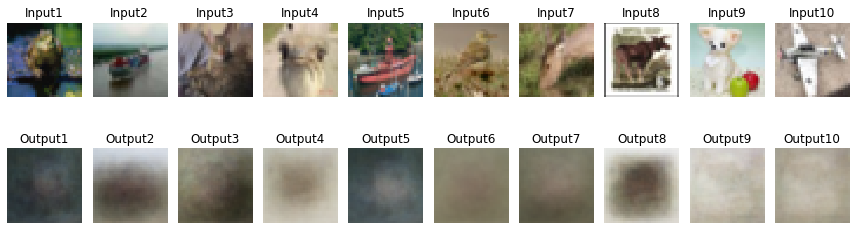

Iter:600, Loss:0.1197                                                                                                             
Iter:700, Loss:0.1163                                                                                                             
Iter:800, Loss:0.1093                                                                                                             
Iter:900, Loss:0.1091                                                                                                             
Iter:1000, Loss:0.1019                                                                                                             
save >> models/AE_cifar10_iter1000.pt


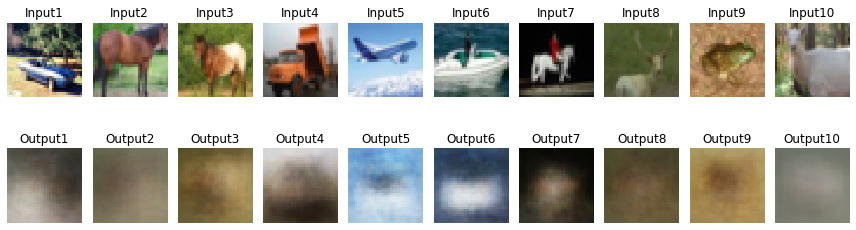

result was saved to >> result/AE_cifar10_result_iter1000.jpg
Iter:1100, Loss:0.1050                                                                                                                      
Iter:1200, Loss:0.1054                                                                                                                      
Iter:1300, Loss:0.1108                                                                                                                      
Iter:1400, Loss:0.1041                                                                                                                      
Iter:1500, Loss:0.0983                                                                                                                      


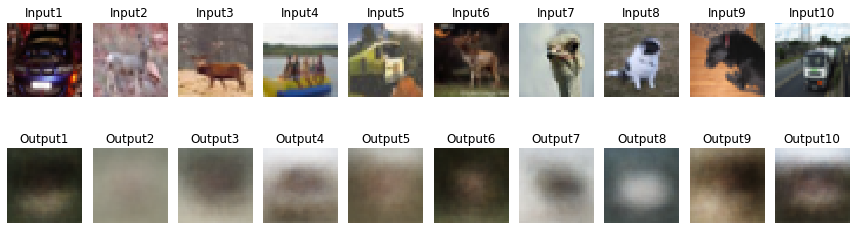

Iter:1600, Loss:0.0982                                                                                                                      
Iter:1700, Loss:0.1010                                                                                                                      
Iter:1800, Loss:0.0983                                                                                                                      
Iter:1900, Loss:0.0972                                                                                                                      
Iter:2000, Loss:0.0951                                                                                                                      
save >> models/AE_cifar10_iter2000.pt


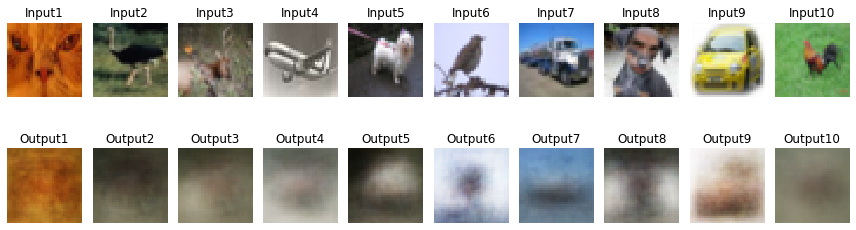

result was saved to >> result/AE_cifar10_result_iter2000.jpg
Iter:2100, Loss:0.0968                                                                                                                      
Iter:2200, Loss:0.0902                                                                                                                      
Iter:2300, Loss:0.0982                                                                                                                      
Iter:2400, Loss:0.0939                                                                                                                      
Iter:2500, Loss:0.0911                                                                                                                      


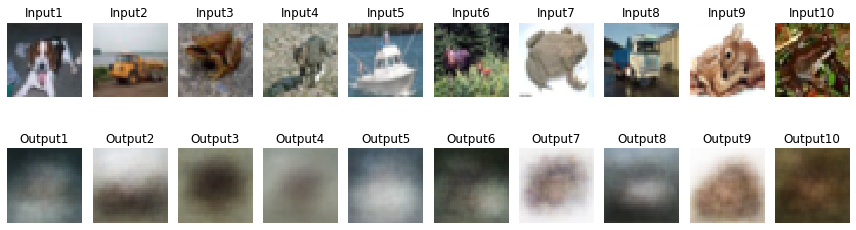

Iter:2600, Loss:0.0906                                                                                                                      
Iter:2700, Loss:0.0943                                                                                                                      
Iter:2800, Loss:0.0908                                                                                                                      
Iter:2900, Loss:0.0858                                                                                                                      
Iter:3000, Loss:0.0903                                                                                                                      
save >> models/AE_cifar10_iter3000.pt


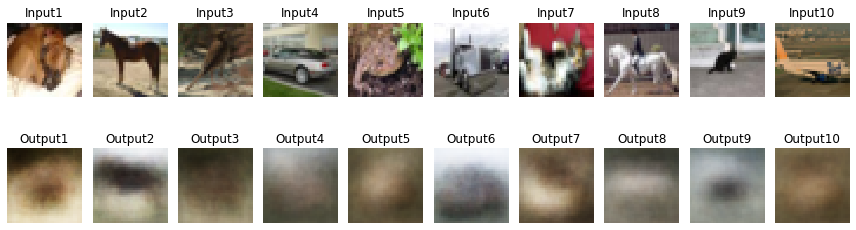

result was saved to >> result/AE_cifar10_result_iter3000.jpg
Iter:3100, Loss:0.0867                                                                                                                      
Iter:3200, Loss:0.0910                                                                                                                      
Iter:3300, Loss:0.0855                                                                                                                      
Iter:3400, Loss:0.0923                                                                                                                      
Iter:3500, Loss:0.0946                                                                                                                      


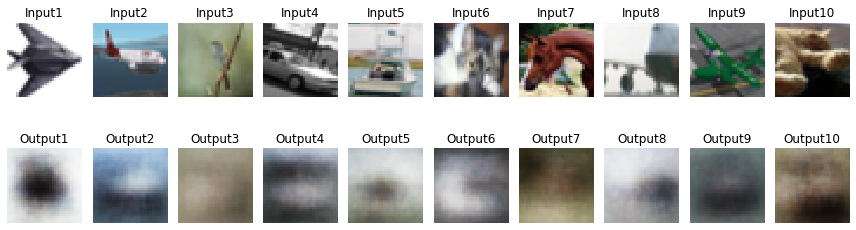

Iter:3600, Loss:0.0977                                                                                                                      
Iter:3700, Loss:0.0903                                                                                                                      
Iter:3800, Loss:0.0862                                                                                                                      
Iter:3900, Loss:0.0899                                                                                                                      
Iter:4000, Loss:0.0831                                                                                                                      
save >> models/AE_cifar10_iter4000.pt


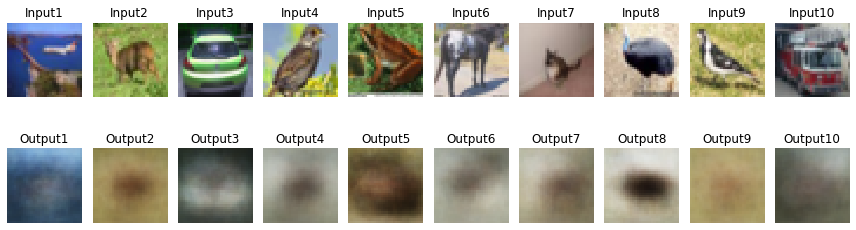

result was saved to >> result/AE_cifar10_result_iter4000.jpg
Iter:4100, Loss:0.0919                                                                                                                      
Iter:4200, Loss:0.0889                                                                                                                      
Iter:4300, Loss:0.0884                                                                                                                      
Iter:4400, Loss:0.0809                                                                                                                      
Iter:4500, Loss:0.0899                                                                                                                      


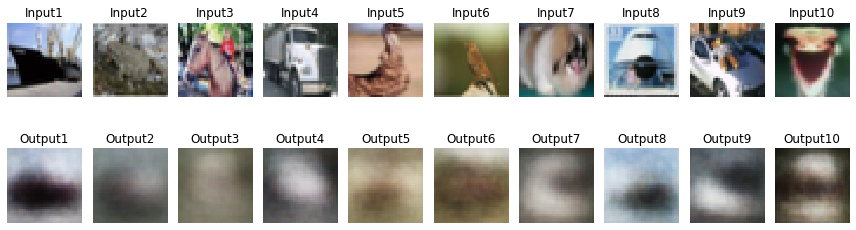

Iter:4600, Loss:0.0851                                                                                                                      
Iter:4700, Loss:0.0831                                                                                                                      
Iter:4800, Loss:0.0864                                                                                                                      
Iter:4900, Loss:0.0828                                                                                                                      
Iter:5000, Loss:0.0874                                                                                                                      
save >> models/AE_cifar10_iter5000.pt


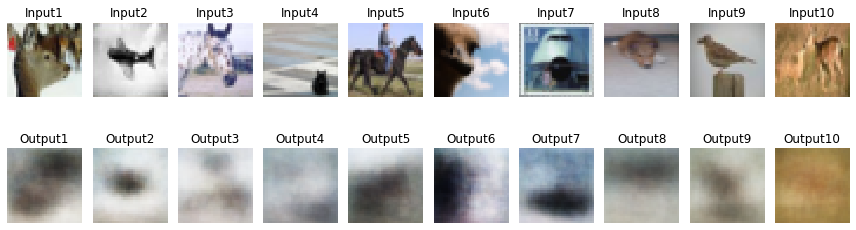

result was saved to >> result/AE_cifar10_result_iter5000.jpg
Iter:5100, Loss:0.0884                                                                                                                      
Iter:5200, Loss:0.0835                                                                                                                      
Iter:5300, Loss:0.0844                                                                                                                      
Iter:5400, Loss:0.0852                                                                                                                      
Iter:5500, Loss:0.0818                                                                                                                      


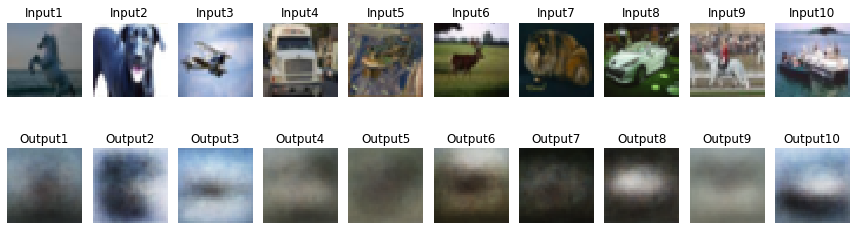

Iter:5600, Loss:0.0882                                                                                                                      
Iter:5700, Loss:0.0881                                                                                                                      
Iter:5800, Loss:0.1519                                                                                                                      
Iter:5900, Loss:0.1348                                                                                                                      
Iter:6000, Loss:0.1245                                                                                                                      
save >> models/AE_cifar10_iter6000.pt


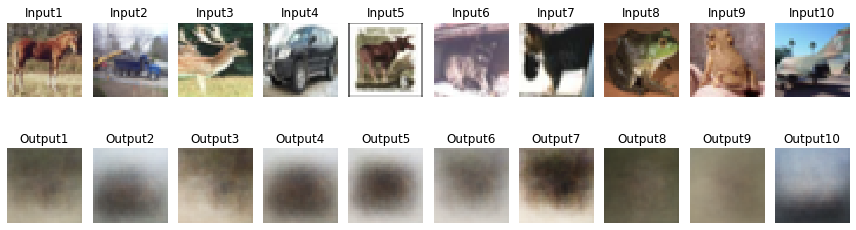

result was saved to >> result/AE_cifar10_result_iter6000.jpg
Iter:6100, Loss:0.1204                                                                                                                      
Iter:6200, Loss:0.1238                                                                                                                      
Iter:6300, Loss:0.1161                                                                                                                      
Iter:6400, Loss:0.1256                                                                                                                      
Iter:6500, Loss:0.1224                                                                                                                      


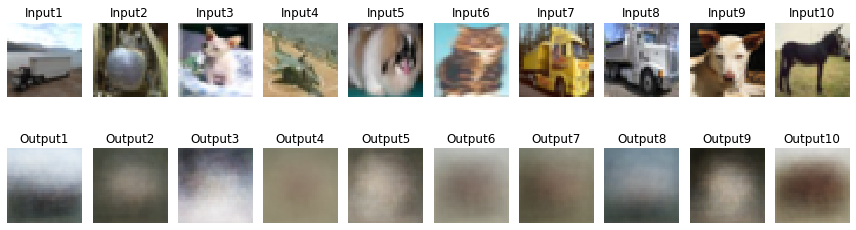

Iter:6600, Loss:0.1088                                                                                                                      
Iter:6700, Loss:0.1129                                                                                                                      
Iter:6800, Loss:0.1141                                                                                                                      
Iter:6900, Loss:0.1179                                                                                                                      
Iter:7000, Loss:0.1066                                                                                                                      
save >> models/AE_cifar10_iter7000.pt


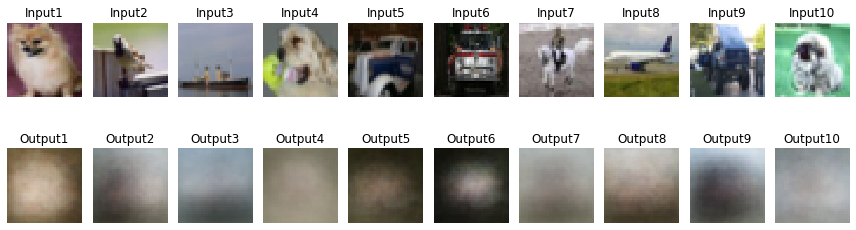

result was saved to >> result/AE_cifar10_result_iter7000.jpg
Iter:7100, Loss:0.1127                                                                                                                      
Iter:7200, Loss:0.1042                                                                                                                      
Iter:7300, Loss:0.1084                                                                                                                      
Iter:7400, Loss:0.1074                                                                                                                      
Iter:7500, Loss:0.1055                                                                                                                      


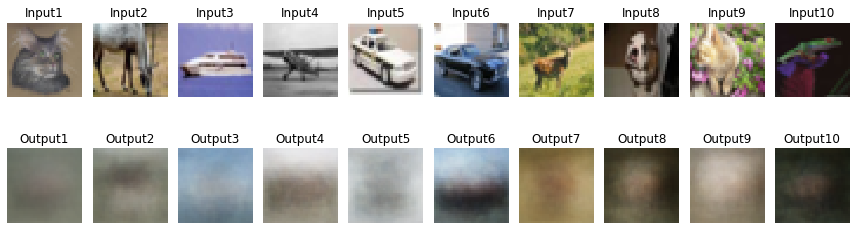

Iter:7600, Loss:0.1070                                                                                                                      
Iter:7700, Loss:0.1073                                                                                                                      
Iter:7800, Loss:0.1006                                                                                                                      
Iter:7900, Loss:0.1026                                                                                                                      
Iter:8000, Loss:0.0998                                                                                                                      
save >> models/AE_cifar10_iter8000.pt


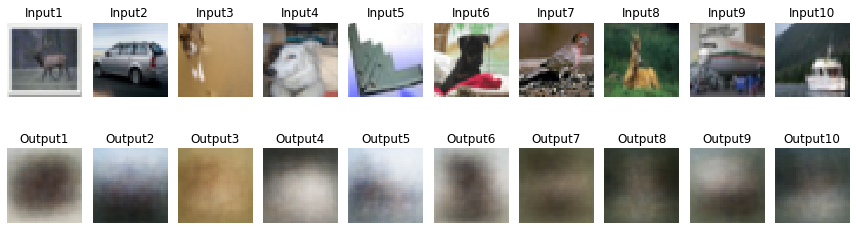

result was saved to >> result/AE_cifar10_result_iter8000.jpg
Iter:8100, Loss:0.1037                                                                                                                      
Iter:8200, Loss:0.0980                                                                                                                      
Iter:8300, Loss:0.0977                                                                                                                      
Iter:8400, Loss:0.0931                                                                                                                      
Iter:8500, Loss:0.0918                                                                                                                      


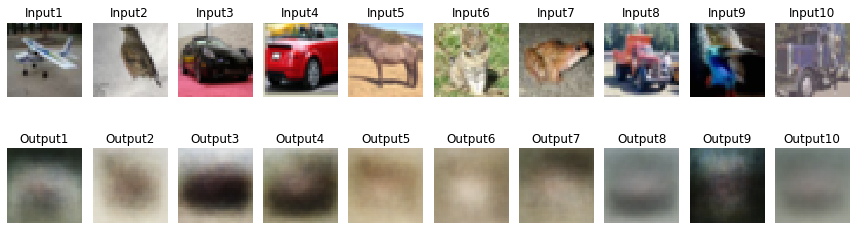

Iter:8600, Loss:0.0956                                                                                                                      
Iter:8700, Loss:0.0930                                                                                                                      
Iter:8800, Loss:0.0955                                                                                                                      
Iter:8900, Loss:0.0967                                                                                                                      
Iter:9000, Loss:0.0945                                                                                                                      
save >> models/AE_cifar10_iter9000.pt


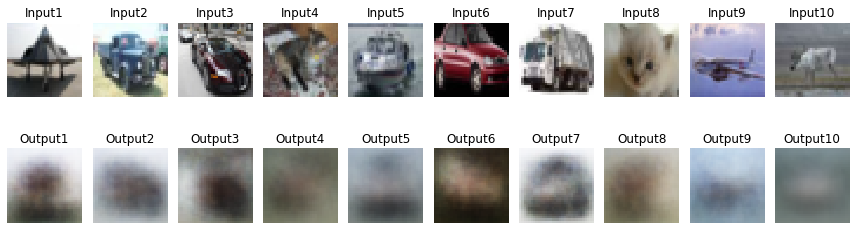

result was saved to >> result/AE_cifar10_result_iter9000.jpg
Iter:9100, Loss:0.1002                                                                                                                      
Iter:9200, Loss:0.0937                                                                                                                      
Iter:9300, Loss:0.0913                                                                                                                      
Iter:9400, Loss:0.0934                                                                                                                      
Iter:9500, Loss:0.0953                                                                                                                      


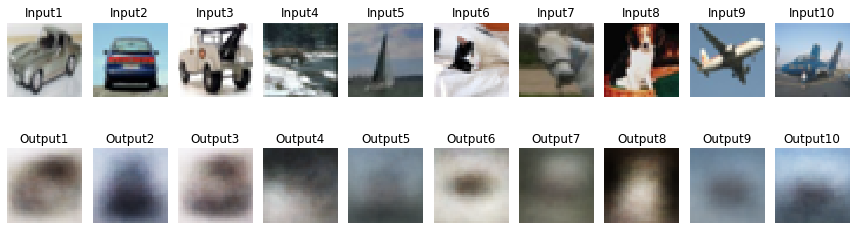

Iter:9600, Loss:0.0930                                                                                                                      
Iter:9700, Loss:0.0897                                                                                                                      
Iter:9800, Loss:0.0900                                                                                                                      
Iter:9900, Loss:0.0880                                                                                                                      
Iter:10000, Loss:0.0917                                                                                                                      
save >> models/AE_cifar10_iter10000.pt


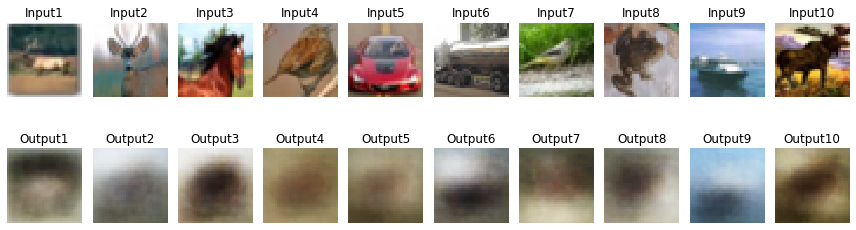

result was saved to >> result/AE_cifar10_result_iter10000.jpg
final paramters were saved to >> models/AE_cifar10_final.pt
loss was saved to >> result/AE_cifar10_loss.txt


In [7]:
# train
def train():
    # model
    model = AE().to(cfg.DEVICE)
    
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)
    
    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.CIFAR10(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = trainset.data
    train_ts = trainset.targets
    
    print('training data : ', train_Xs.shape)

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # get minibatch
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # train
        opt.zero_grad()

        # sample X, y
        Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.INPUT_MODE, 
                                    hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION),
                          dtype=torch.float).to(cfg.DEVICE)
        #ts = torch.tensor(train_ts[mb_ind], dtype=torch.float).to(device)

        # forward
        ys = model(Xs)
        # loss
        loss = cfg.TRAIN.LOSS_FUNCTION(ys, Xs.view(cfg.TRAIN.MINIBATCH, -1))
        # update
        loss.backward()
        opt.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss = loss.item()

        if (i + 1) % cfg.TRAIN.LEARNING_PROCESS_PROGRESS_INTERVAL == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
    
        # display training state
        if (i + 1) % cfg.TRAIN.DISPLAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f} '.format(i + 1, _loss))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model.state_dict(), save_path)
            print('save >> {}'.format(save_path))

        # show process result
        if (cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW != False) and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_SHOW == 0):
            result_show(
                model, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=False, show=True, cmap=cfg.OUTPUT_CMAP)
            
        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                model, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=True, show=False, cmap=cfg.OUTPUT_CMAP)

    save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
    torch.save(model.state_dict(), save_path)
    print('final paramters were saved to >> {}'.format(save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------
--------------------
AE config
- Input : 32 x 32 x 3
- encoder 1 : 3072 > 256
- encoder 2 : 256 > 128
- encoder 3 : 128 > 64
- encoder 4 : 64 > 32
- decoder 4 : 32 > 64
- decoder 3 : 64 > 128
- decoder 2 : 128 > 256
- decoder 1 : 256 > 3072
- Output : (32 x 32 x 3)
--------------------
Files already downloaded and verified


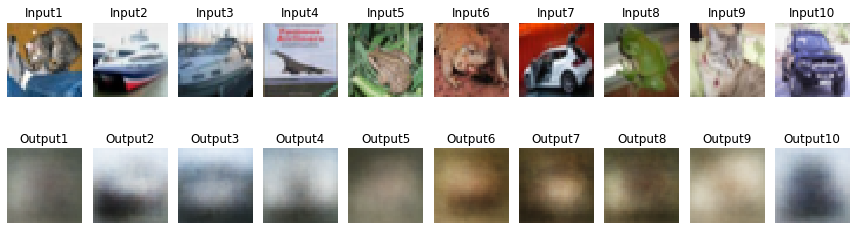

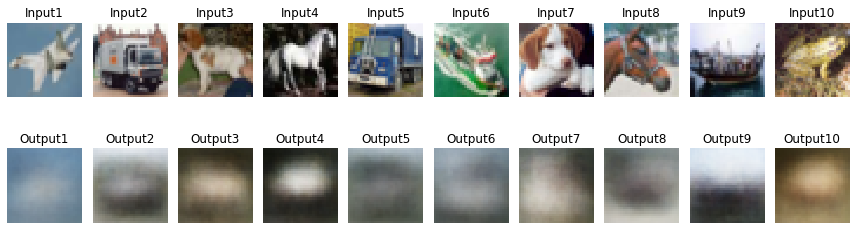

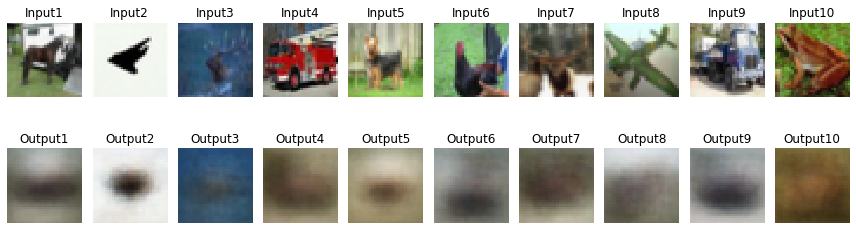

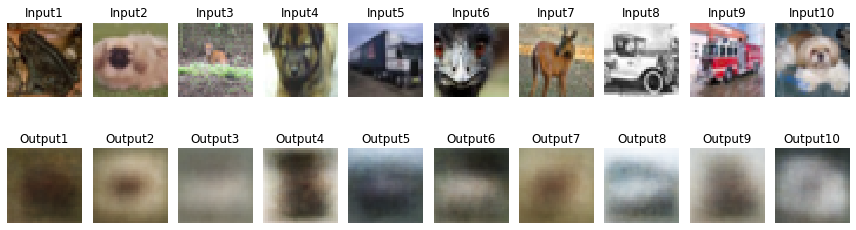

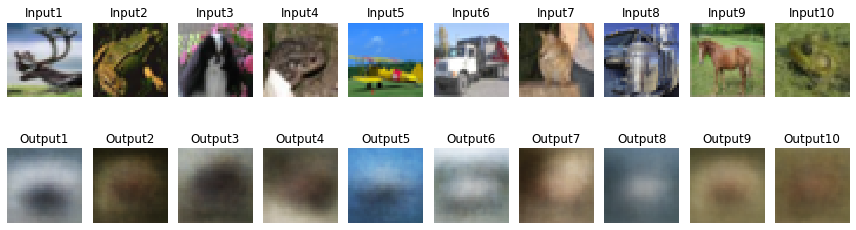

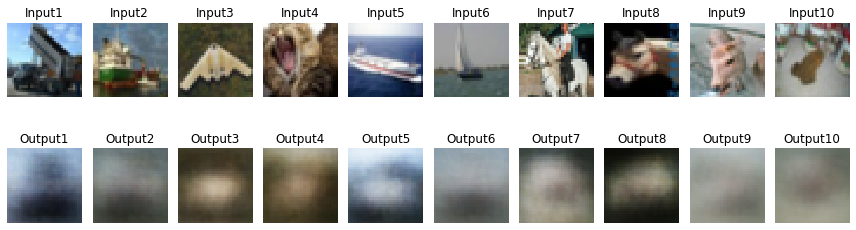

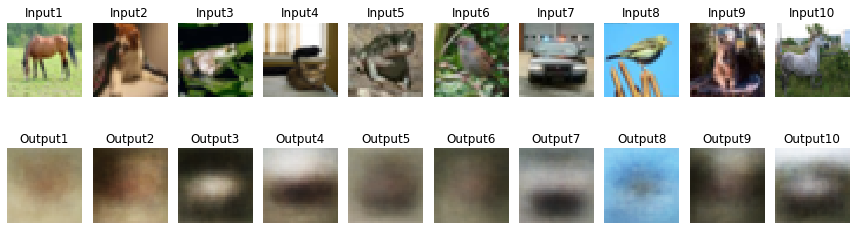

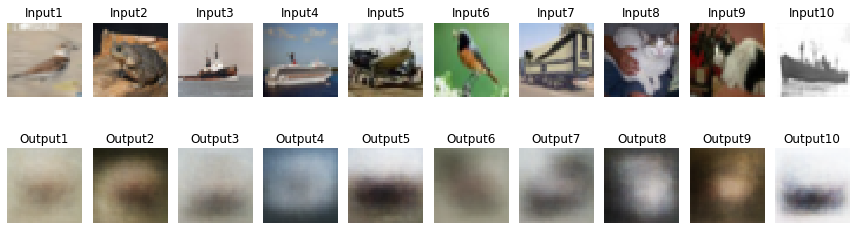

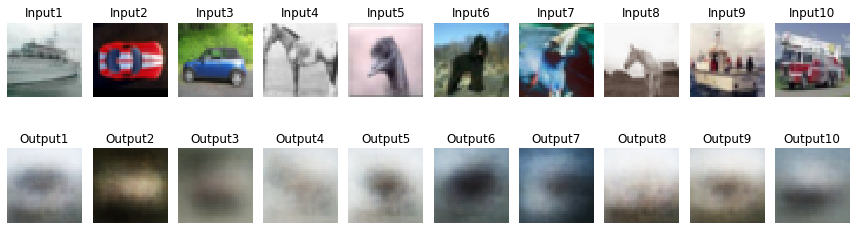

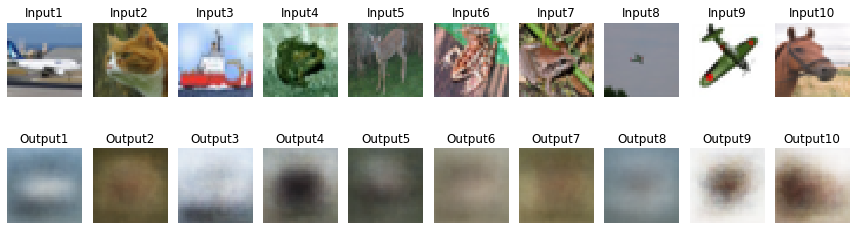

In [8]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    
    model = AE().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    #path_dict = data_load(cfg, train=False, hf=False, vf=False, rot=False)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']
    
    trainset = torchvision.datasets.CIFAR10(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    train_Xs = trainset.data
    train_ts = trainset.targets
    
    Test_Num = min(len(train_Xs), cfg.TEST.MAX_SAMPLES)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for i in range(0, Test_Num, cfg.TEST.MINIBATCH):
            mb_ind = np.arange(i, min(i + cfg.TEST.MINIBATCH, Test_Num))
            
            # sample X, y
            Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.INPUT_MODE, hf=False, vf=False, rot=False), dtype=torch.float).to(cfg.DEVICE)           

            result_show(model, Xs, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), 
                        save=cfg.TEST.RESULT_SAVE, show=True, cmap=cfg.OUTPUT_CMAP)

test()